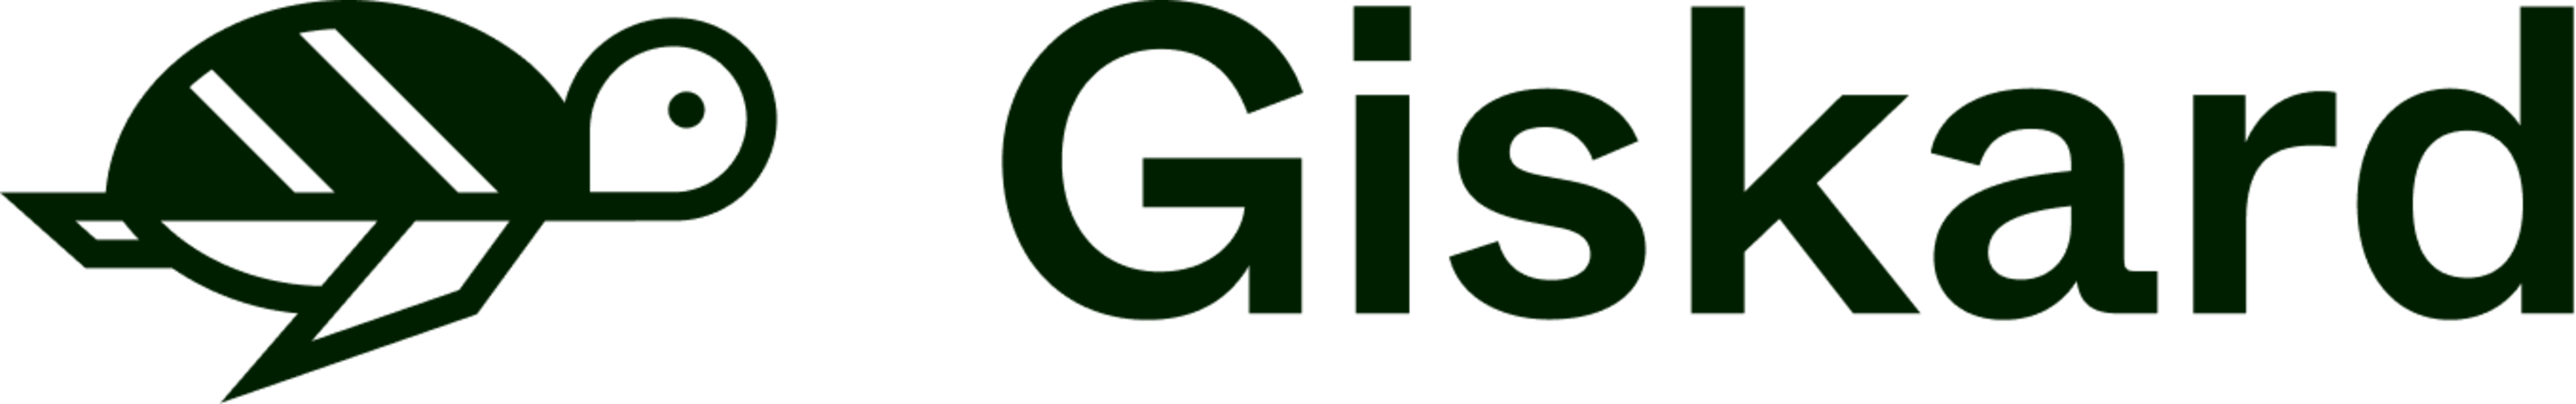

# About Giskard

Open-Source CI/CD platform for ML teams. Deliver ML products, better & faster. 

*   Collaborate faster with feedback from business stakeholders.
*   Deploy automated tests to eliminate regressions, errors & biases.

🏡 [Website](https://giskard.ai/)

📗 [Documentation](https://docs.giskard.ai/)

# Start by creating a ML model 🚀🚀🚀

Download the categorized email files from Berkeley.

In [ ]:
!wget http://bailando.sims.berkeley.edu/enron/enron_with_categories.tar.gz
!tar zxf enron_with_categories.tar.gz
!rm enron_with_categories.tar.gz

In [ ]:
!pip install giskard

In [ ]:
import email
import glob
import time
import math
from collections import defaultdict, namedtuple

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

import numpy as np

import pandas as pd
import datetime
from dateutil import parser

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import model_selection

import tensorflow_hub as hub
import tensorflow_text as text

Various imports and the list of categories from http://bailando.sims.berkeley.edu/enron/enron_categories.txt.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

stoplist = set(stopwords.words('english') + list(punctuation))
stemmer = PorterStemmer()


# http://bailando.sims.berkeley.edu/enron/enron_categories.txt
idx_to_cat = {
    1: 'REGULATION',
    2: 'INTERNAL',
    3: 'INFLUENCE',
    4: 'INFLUENCE',
    5: 'INFLUENCE',
    6: 'CALIFORNIA CRISIS',
    7: 'INTERNAL',
    8: 'INTERNAL',
    9: 'INFLUENCE',
    10: 'REGULATION',
    11: 'talking points',
    12: 'meeting minutes',
    13: 'trip reports'}

idx_to_cat2 = {
    1: 'regulations and regulators (includes price caps)',
    2: 'internal projects -- progress and strategy',
    3: ' company image -- current',
    4: 'company image -- changing / influencing',
    5: 'political influence / contributions / contacts',
    6: 'california energy crisis / california politics',
    7: 'internal company policy',
    8: 'internal company operations',
    9: 'alliances / partnerships',
    10: 'legal advice',
    11: 'talking points',
    12: 'meeting minutes',
    13: 'trip reports'}


LABEL_CAT = 3  # we'll be using the 2nd-level category "Primary topics" because the two first levels provide categories that are not mutually exclusive. see : https://bailando.berkeley.edu/enron/enron_categories.txt

#get_labels returns a dictionary representation of these labels. 
def get_labels(filename):
    with open(filename + '.cats') as f:
        labels = defaultdict(dict)
        line = f.readline()
        while line:
            line = line.split(',')
            top_cat, sub_cat, freq = int(line[0]), int(line[1]), int(line[2])
            labels[top_cat][sub_cat] = freq
            line = f.readline()
    return dict(labels)


email_files = [f.replace('.cats', '') for f in glob.glob('enron_with_categories/*/*.cats')]

##Build dataframe

In [ ]:
columns_name = ['Target', 'Subject', 'Content', 'Week_day', 'Year', 'Month', 'Hour', 'Nb_of_forwarded_msg']


data = pd.DataFrame(columns=columns_name)

for email_file in email_files:
    values_to_add = {}

    #Target is the sub-category with maximum frequency
    if LABEL_CAT in get_labels(email_file):
      sub_cat_dict = get_labels(email_file)[LABEL_CAT]
      target_int = max(sub_cat_dict, key=sub_cat_dict.get)
      values_to_add['Target'] = str(idx_to_cat[target_int])

    #Features are metadata from the email object
    filename = email_file+'.txt'
    with open(filename) as f:

      message = email.message_from_string(f.read())
  
      values_to_add['Subject'] = str(message['Subject'])
      values_to_add['Content'] = str(message.get_payload())
     
      date_time_obj = parser.parse(message['Date'])
      values_to_add['Week_day'] = date_time_obj.strftime("%A")
      values_to_add['Year'] = date_time_obj.strftime("%Y")
      values_to_add['Month'] = date_time_obj.strftime("%B")
      values_to_add['Hour'] = int(date_time_obj.strftime("%H"))

      # Count number of forwarded mails
      number_of_messages = 0
      for line in message.get_payload().split('\n'):
        if ('forwarded' in line.lower() or 'original' in line.lower()) and '--' in line:
            number_of_messages += 1
      values_to_add['Nb_of_forwarded_msg'] = number_of_messages
    
    row_to_add = pd.Series(values_to_add)
    data = data.append(row_to_add, ignore_index=True)

Filter Dataframe

In [ ]:
#We filter 879 rows (if Primary topics exists (i.e. if coarse genre 1.1 is selected) )
data_filtered = data[data["Target"].notnull()]

#Exclude target category with very few rows ; 812 rows remains
excluded_category = [idx_to_cat[i] for i in [11,12,13]]
data_filtered = data_filtered[data_filtered["Target"].isin(excluded_category) == False]



Training with scikit learn pipeline

In [ ]:
text_transformer = Pipeline([
                      ('vect', CountVectorizer(stop_words=stoplist)),
                      ('tfidf', TfidfTransformer())
                     ])
preprocessor = ColumnTransformer(
    transformers=[
      ('text_Mail', text_transformer, "Content")
    ]
)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter =1000))])

Split train/test

In [ ]:
column_types={       
        'Target': "category",
        "Subject": "text",
        "Content": "text",
        "Week_day": "category",
        "Month": "category",
        "Hour": "numeric",
        "Nb_of_forwarded_msg": "numeric",
        "Year": "numeric"
    }

In [ ]:
feature_types = {i:column_types[i] for i in column_types if i!="Target"}
Y = data_filtered["Target"]
X = data_filtered.drop(columns="Target")
X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X, Y,test_size=0.20, random_state = 30, stratify = Y)

Learning phase

In [ ]:
clf.fit(X_train, Y_train)
print("model score: %.3f" % clf.score(X_test, Y_test))

In [ ]:
train_data = pd.concat([X_train, Y_train], axis=1)
test_data = pd.concat([X_test, Y_test ], axis=1)

#Upload the model in Giskard 🚀🚀🚀

### Initiate a project


In [ ]:
from giskard.giskard_client import GiskardClient

url = "http://localhost:9000" # if docker image is running on your local
#url = "http://app.giskard.ai" # If you want to upload on giskard URL 

token = "XXX" #Find your token in the Admin tab of your app (login: admin; password: admin)

client = GiskardClient(url, token)

enron = client.create_project("enron_demo", "Enron Mails Classification", "Project to classify enron mails")

#If you've already created a project with the key "enron_demo" use
#enron = client.get_project("enron_demo")

### Upload your model and a dataset (see [documentation](https://docs.giskard.ai/start/guides/upload-your-model))

In [ ]:
enron.upload_model_and_df(
    prediction_function=clf.predict_proba, 
    model_type='classification',
    df=test_data, #the dataset you want to use to inspect your model
    column_types=column_types, #all the column types of df
    target='Target', #the column name in df corresponding to the actual target variable (ground truth).
    feature_names=list(feature_types.keys()),#list of the feature names of prediction_function
    model_name='logistic_regression_model',
    dataset_name='test_data',
    classification_labels=clf.classes_
)

### 🌟 If you want to upload a dataset without a model


For example, let's upload the train set in Giskard, this is key to create drift tests in Giskard.

In [ ]:
enron.upload_df(
    df=train_data,
    column_types=column_types, #all the column types of df
    target="Target", # do not pass this parameter if dataset doesnt contain target column 
    name="train_data"
)

You can also upload new production data to use it as a validatation set for your existing model. In that case, you might not have the ground truth target variable